# SMCityDAS
### CS230 Spring 2023
#### Authors:
**Thomas Cullison**
<br>
**Haipeng Li**
<br>
**Hassan Almomin**

# DAS Data Compression using Autoencoder

This notebook demonstraights the use of an autoencoder model for lossy DAS data compression.  The model code we started from can be found here (we had to make modification for our purposes): [TensorFlow Compression](https://github.com/tensorflow/compression).

## Paper and posts for understanding related theories

1. [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)
2. [Image Compression Using Autoencoders in Keras](https://blog.paperspace.com/autoencoder-image-compression-keras/)
3. [AI-Based Image Compression: The State of the Art](https://towardsdatascience.com/ai-based-image-compression-the-state-of-the-art-fb5aa6042bfa)

## Setup

### Install Tensorflow Compression via `pip`.

In [ ]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 5.5 MB/s eta 0:00:00


### Install numba

In [ ]:
!python -m pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Install scikit-image

In [ ]:
!python -m pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mount Google Drive

In [ ]:
# Mount my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Copy custom python

In [ ]:
# Define root path to drive
root_fqdn = "./drive/MyDrive/SMCityData/"

In [ ]:
!cp {root_fqdn}python/utils.py /content

In [ ]:
!cp {root_fqdn}python/model.py /content

In [ ]:
!ls {root_fqdn}python

model.py	       utils_old.py  utils_v2.py  utils_v4.py
utils_before_final.py  utils.py      utils_v3.py  utils_v5.py


In [ ]:
#!cp /content/utils.py {root_fqdn}python/utils.py

In [ ]:
#!cp /content/model.py {root_fqdn}python/model.py

### Import python, plotting, and tensorflow modules

In [ ]:
import glob
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tnp

#TAC: moved these imports down a few cells

plt.rcParams.update({'font.size': 14})

### Import Model and Utils 

In [ ]:
%load_ext autoreload
%autoreload 2
#TAC: above for loading new changes

from model import train_das_model, make_das_codec
from utils import extract_image_patches, extract_image_patches_fast, prepare_das_dataset 
from utils import reconstruct_image_from_patches, load_patch_from_file, norm_channel, chan_xcorr

### Creat list of path + filenames to preprocessed DAS data 

In [ ]:

# Set the data for trainning
# TAC: This will load only YOUR Google Drive. 
#file_train = sorted(glob.glob('./drive/MyDrive/DeepLearning/train/*.npz'))
#file_test = sorted(glob.glob('./drive/MyDrive/DeepLearning/test/*.npz'))
#file_train = sorted(glob.glob('./drive/MyDrive/SMCityData/train/smcity_sandhill*.npz')) #TAC data
#file_test = sorted(glob.glob('./drive/MyDrive/SMCityData/test/smcity_sandhill*.npz'))   #TAC data
file_train = sorted(glob.glob(root_fqdn+'train/*.npz')) #TAC data
file_test = sorted(glob.glob(root_fqdn+'test/*.npz'))   #TAC data

print("\n--------------Trainning Dataset--------------\n")
print(file_train)

print("\n--------------Test Dataset--------------\n")
print(file_test)


--------------Trainning Dataset--------------

['./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T10-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T14-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T19-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-03_T00-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T10-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T14-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T19-00-55_p10min.npz', './drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2

# Prep data for training

### Set trainging data parameters

In [ ]:
# Setup parameters for generating patches
patch_size = 32         # size of each patch
train_ratio = 0.95      # ratio between training and dev 
shuffle = True           # shuffle all patches or not
overlap = True          # overlap or not when retriving patches, i.e., tile for half patch_size
add_noise = False        # add random noise to each patch or not
snr = 150                 # value for signal-to-noise ratio

### Load data and convert to patches for traing

In [ ]:
%%time

# Create patches from files (read all but the last file which we using for testing)
# Should take about 1 min if reading all but last file
# Note: output patches are labels
input_patches, ouput_patches, factors = load_patch_from_file(file_train[:-1], patch_size, overlap = overlap, add_noise = add_noise, snr = snr)
print('Done loading to patches')
print(f'isize: {len(input_patches)}')
print(f'osize: {len(ouput_patches)}')
print(f'fsize: {len(factors)}')


Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T10-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T14-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-02_T19-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-03_T00-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T10-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T14-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D2022-10-04_T19-00-55_p10min.npz
Loading: ./drive/MyDrive/SMCityData/train/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2.0_D

### Convert patches to tf_tensors and make train and dev datasets

In [ ]:
%%time
# Prepare the training and dev dataset into tensorflow
# Includes shuffleing
# Should take about 3 minutes is using all but last file
train_dataset, dev_dataset = prepare_das_dataset(input_patches, ouput_patches, train_ratio = train_ratio, shuffle = shuffle)
print('Done make datasets')



Number of train data:  685242
Number of valid data:  36066
<_ZipDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>
<_ZipDataset element_spec=(TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, 32, 1), dtype=tf.float32, name=None))>
Done make datasets
CPU times: user 3min 18s, sys: 4.1 s, total: 3min 23s
Wall time: 3min 21s


### Compare an input patch to an output (label) patch

721308


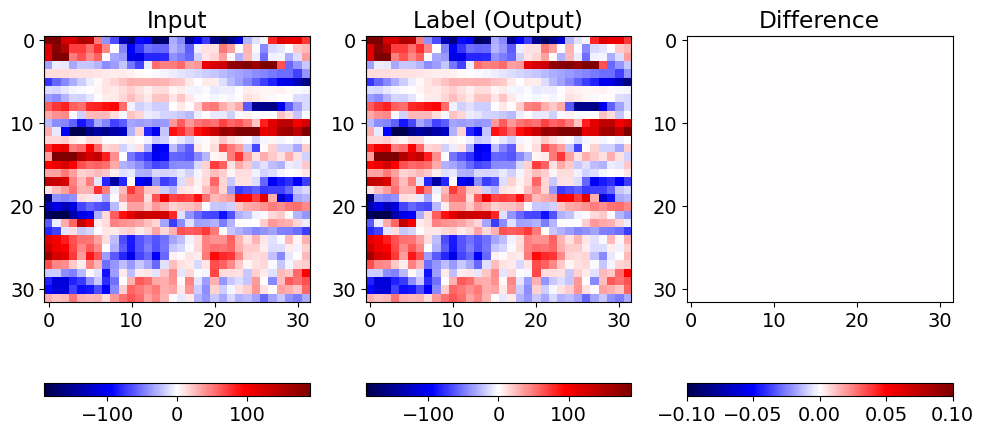

In [ ]:
# Pick a patch and compare input and label (output)
idx = 42
print(len(input_patches))

ptitles = ['Input','Label (Output)', 'Difference']

plt.figure(figsize=(10, 5))
for i,data in enumerate([input_patches[idx], 
                         ouput_patches[idx], 
                         input_patches[idx] - ouput_patches[idx]]):
  
  pclip = np.percentile(data, 99.)
  plt.subplot(1,3,i+1)
  plt.imshow(data, cmap='seismic', vmin=-pclip, vmax=pclip)
  plt.title(ptitles[i])
  plt.colorbar(orientation="horizontal",fraction=0.07,anchor=(1.0,0.0))
  
plt.tight_layout()

# Train the model

### Set model hyperparameters

In [ ]:
# Setup parameters for training model
lmbda = 64000         # weight for rate–distortion Lagrangian
latent_dims = 500     # layers in latent space
epochs = 100           # epoch
batch_size = 2048     # batch size
learning_rate = 1e-3  # learning rate
validation_freq = 1   # validation frequency

### Train model

In [ ]:
trainer, history = train_das_model(
                    train_dataset,                         # training dataset
                    dev_dataset,                           # dev dataset
                    lmbda=lmbda,                           # weight for rate–distortion Lagrangian
                    latent_dims=latent_dims,               # layers in latent space
                    patch_size = patch_size,               # patch size of the image, must be dividable by 4
                    epochs=epochs,                         # epoch
                    batch_size=batch_size,                 # batch size
                    learning_rate=learning_rate,           # learning rate
                    validation_freq=validation_freq,       # validation frequency
                    launch_trainer = True)                 # launch the trainer
                    

Epoch 1/100
335/335 [==============================] - ETA: 0s - loss: 7817.4932 - distortion_loss: 0.1061 - rate_loss: 1029.6934 - distortion_pass_through_loss: 0.1060 - rate_pass_through_loss: 1029.6514

335/335 [==============================] - 16s 36ms/step - loss: 7817.4932 - distortion_loss: 0.1061 - rate_loss: 1029.6934 - distortion_pass_through_loss: 0.1060 - rate_pass_through_loss: 1029.6514 - val_loss: 6452.2065 - val_distortion_loss: 0.0854 - val_rate_loss: 988.7008 - val_distortion_pass_through_loss: 0.0854 - val_rate_pass_through_loss: 988.8066
Epoch 2/100
335/335 [==============================] - 11s 34ms/step - loss: 6101.8438 - distortion_loss: 0.0804 - rate_loss: 958.6931 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 958.6496 - val_loss: 5809.5522 - val_distortion_loss: 0.0764 - val_rate_loss: 922.4246 - val_distortion_pass_through_loss: 0.0764 - val_rate_pass_through_loss: 922.5709
Epoch 3/100
335/335 [==============================] - 12s 34ms/step - loss: 5691.2446 - distortion_loss: 0.0748 - rate_loss: 902.8580 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 902.8279 - val_loss: 5552.2861 - val_distortion_loss: 0.0731 - val_rate_

### Plot losses

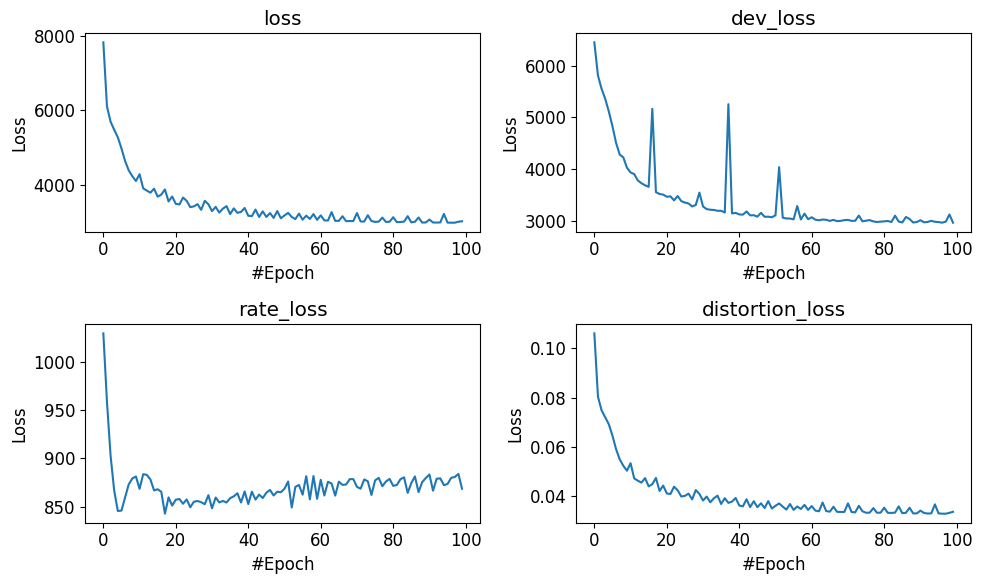

In [ ]:
#history.history.keys()
loss_list = ['loss', 'val_loss', 'rate_loss', 'distortion_loss']
loss_titles = ['loss', 'dev_loss', 'rate_loss', 'distortion_loss']

# Plot the rate_loss curve.
plt.figure(figsize=(10,6))
for i, l in enumerate(loss_list):
  plt.subplot(2, 2, i + 1)
  plt.plot(history.history[l])
  plt.xlabel('#Epoch')
  plt.ylabel('Loss')
  plt.title(loss_titles[i])

plt.tight_layout()
plt.savefig('Loss.png', dpi=300, pad_inches=0.1)
plt.show()

## Save the model to disk

In [ ]:
# fqdn for the the model weights either for saving or reading
#path = "./drive/MyDrive/DeepLearning/results/"
path = root_fqdn+"results/" #TAC
name = f"model_patch{patch_size}_lmbda{lmbda}_latent{latent_dims}_learning_rate{learning_rate}"
fqdn = path+name
print(fqdn)

./drive/MyDrive/SMCityData/results/model_patch32_lmbda64000_latent500_learning_rate0.001


In [ ]:
# Save the model for testing
trainer.save_weights(os.path.join(path, name))

NameError: ignored

In [ ]:
# Verifty model was saved
!ls {fqdn}*

./drive/MyDrive/SMCityData/results/model_patch32_lmbda64000_latent500_learning_rate0.001.data-00000-of-00001
./drive/MyDrive/SMCityData/results/model_patch32_lmbda64000_latent500_learning_rate0.001.index


# Test against data not included in training

### Construct compressor and decompressor (encoder and decoder)

In [ ]:
# Construct model without training
trainer_for_test, _ = train_das_model(
                    None,                                  # training dataset  <--- LOOK!
                    None,                                  # dev dataset       <--- LOOK!
                    lmbda=lmbda,                           # weight for rate–distortion Lagrangian
                    latent_dims=latent_dims,               # layers in latent space
                    patch_size = patch_size,               # patch size of the image, must be dividable by 4
                    epochs=epochs,                         # epoch
                    batch_size=batch_size,                 # batch size
                    learning_rate=learning_rate,           # learning rate
                    validation_freq=validation_freq,       # validation frequency
                    launch_trainer = False)                # launch the trainer


# load the pretrained model
trainer_for_test.load_weights(os.path.join(path, name))

# Setup the trained model 
compressor, decompressor = make_das_codec(trainer_for_test)


## Test the reconstruction for DAS data not used for trianing

### Set indices for file used for test data and one for non-similar data
The non-similar data has the same channels but different time to compare with cross-correlation results shown near the bottomw of the notebook.

In [ ]:
# which file for testing (last file not used for training)
test_idx = 6 #TAC: last file

# which file for x-correlation of dissimilar images (negative control)
xcor_idx = 5 #TAC: second to last file (so same geographic region but different time)

### Conver test data and non-similar data into patches

In [ ]:
# Load the one of the test data
pdata = norm_channel(np.load(file_test[test_idx])['pdata'])
patches_original, _toss, factors = extract_image_patches(pdata, patch_size, add_noise=False)
patches_original = tf.convert_to_tensor(patches_original, dtype=tf.float32)

# These data are used for showing x-correlation between two dissimular data sets (like a negative-control)
xcor_pdata = norm_channel(np.load(file_test[xcor_idx])['pdata'])
xcor_patches, _toss, xfactors = extract_image_patches(xcor_pdata, patch_size, add_noise=False)
xcor_patches = tf.convert_to_tensor(xcor_patches, dtype=tf.float32)

### Compress the patches for the test data

In [ ]:
# Compress the patches to strings, and keep track of each of their information content in bits.
strings, entropies = compressor(patches_original)

### Show info regarding size of compressed data and the entropy bits. 

**When patch_size = 32** we get a 512X compression rate
(Note: when stored to disk, the numpy array object fields take up more bytes than the compressed data).

In [ ]:
from sys import getsizeof
print(f'patch_size: {patch_size}')

len_ptc = len(patches_original)
len_str = len(strings)
len_ent = len(entropies)
np_strings = strings.numpy()
print(f'len(patches): {len_ptc}')
print(f'len(strings): {len_str}')
print(f'strings.nelement(): {strings.dtype}')
print(f'len(entropies): {len_ent}')
print()
print(f'strings.shape: {(strings.shape)}')
print(f'strings.dtype: {(strings.dtype)}')
print(f'np_strings: {(np_strings.nbytes)}')
print(f'np_strings.bytes: {getsizeof(strings[0])/8}')

str_bytes = np_strings.nbytes
ptc_bytes = len_ptc*4*patch_size**2
comp_rat = ptc_bytes/str_bytes
print(f'str_bytes: {str_bytes}')
print(f'ptc_bytes: {ptc_bytes}')
print(f'compression_ratio: {comp_rat}')
print()
print(f'entropies.max: {entropies.numpy().max()}')
print(f'entropies.min: {entropies.numpy().min()}')
print(f'entropies.mean: {entropies.numpy().mean()}')
print(f'entropies.sum: {np.sum(entropies.numpy())/8}')

ibytes = 0
max_bytes = 0
for i in range(len_str):
  tmp = getsizeof(np_strings[i])
  ibytes += tmp
  if max_bytes < tmp:
    max_bytes = tmp
  #print(f'strings[{i}]: {ibytes}')
print(f'total strings.bytes: {ibytes}')
print(f'max strings.bytes: {max_bytes}')

print(getsizeof(['abc']))

patch_size: 32
len(patches): 4200
len(strings): 4200
strings.nelement(): <dtype: 'string'>
len(entropies): 4200

strings.shape: (4200,)
strings.dtype: <dtype: 'string'>
np_strings: 33600
np_strings.bytes: 21.0
str_bytes: 33600
ptc_bytes: 17203200
compression_ratio: 512.0

entropies.max: 1281.4105224609375
entropies.min: 641.5093383789062
entropies.mean: 900.7510986328125
entropies.sum: 472894.3125
total strings.bytes: 613069
max strings.bytes: 194
64


# Analyze compression results

### Decompress the patches from the strings back to data patches (float32 values).

In [ ]:
patches_decompre = decompressor(strings)

### Plot patch comparison

Text(0.5, 1.0, 'Difference')

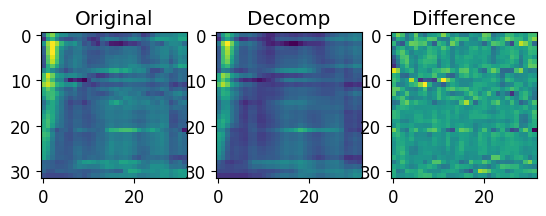

In [ ]:
#patch index
idx = 42

ptitles=['Original','Decomp','Difference']

plt.subplot(1,3,1)
plt.imshow(patches_original[idx])
plt.title(ptitles[0])
plt.subplot(1,3,2)
plt.imshow(patches_decompre[idx])
plt.title(ptitles[1])
plt.subplot(1,3,3)
plt.imshow(patches_original[idx] - patches_decompre[idx])
plt.title(ptitles[2])


### Reconstruct full test dataset from decompressed patches

In [ ]:
# Load the original data just from one file
original_shape = pdata.shape
print('shape of original data: ', original_shape)

original_das = reconstruct_image_from_patches(patches_original, factors, original_shape, patch_size).astype(np.float32)
decompre_das = reconstruct_image_from_patches(patches_decompre, factors, original_shape, patch_size).astype(np.float32)
xcor_das = reconstruct_image_from_patches(xcor_patches, xfactors, original_shape, patch_size).astype(np.float32)

shape of original data:  (4800, 900)


### Save data and compressed patches to disk

In [ ]:
# # Save the compressed data for stand-alone test
# np.save('./drive/MyDrive/Training Dataset/original_das', original_das)
# np.save('./drive/MyDrive/Training Dataset/decompre_das', decompre_das)
# np.save('./drive/MyDrive/Training Dataset/strings.npy', strings.numpy())
# np.save('./drive/MyDrive/Training Dataset/entropies.npy', entropies.numpy())
# np.save('./drive/MyDrive/Training Dataset/patches_original.npy', patches_original.numpy())
# np.save('./drive/MyDrive/Training Dataset/factors.npy', factors)

do_save = True

if do_save:
  tpath = root_fqdn+'results4test/' #TAC
  np.save(tpath+'original_das_idx-{test_idx}', original_das)
  np.save(tpath+'decompre_das_idx-{test_idx}', decompre_das)
  np.save(tpath+'strings_idx-{test_idx}.npy', strings.numpy())
  np.save(tpath+'entropies_idx-{test_idx}.npy', entropies.numpy())
  np.save(tpath+'patches_original_idx-{test_idx}.npy', patches_original.numpy())
  np.save(tpath+'factors_idx-{test_idx}.npy', factors)
  
  # TAC: doesn't make much of a difference
  #np.savez_compressed(tpath+'strings.npz', strings=strings.numpy())
  #np.savez_compressed(tpath+'patches_original.npz', patches_original=patches_original.numpy())
  #np.savez_compressed('factors.npz', factors=factors)

### Read data for strings (if desired). Only needed for testing from disk


In [ ]:
#tpath = root_fqdn+'results4test/' #TAC
#l_np_original_das = np.load(tpath+'original_das_idx-{test_idx}.npy')
#l_np_decompre_das = np.load(tpath+'decompre_das_idx-{test_idx}.npy')
#l_np_strings      = np.load(tpath+'strings_idx-{test_idx}.npy',allow_pickle=True)
#l_np_entropies    = np.load(tpath+'entropies_idx-{test_idx}.npy')
#l_np_patches_original = np.load(tpath+'patches_original_idx-{test_idx}.npy')
#l_np_factors = np.load(tpath+'factors_idx-{test_idx}.npy')

### Run this cell only if you want to test reading the compressed data from disk and then reconstructing

In [ ]:
#strings = tf.convert_to_tensor(l_np_strings)
#entropies = tf.convert_to_tensor(l_np_entropies)

# load normlazation factor
#factors = l_np_factors

### Plot and compare the full test dataste for the original, decompressed, and difference

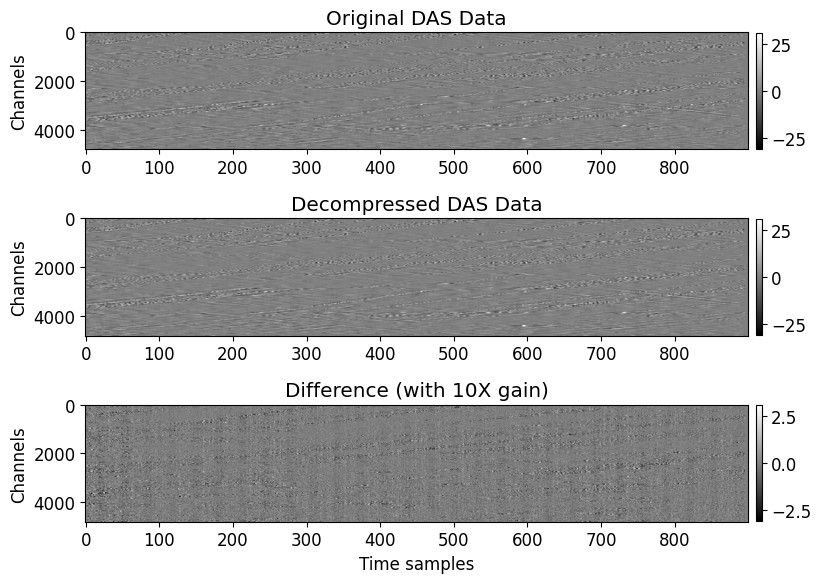

In [ ]:
# plot
plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})

nc = original_shape[0]
rmch = nc%patch_size
nc -= rmch

s_nc = 0
s_nt = 0
# nc = 3000
nt = 900
aspect = 'auto'
vclip = 0.9
diff_gain = 0.1

plt.subplot(311)
orig_plt = original_das[s_nc:nc, s_nt:nt] #TAC
orig_max = np.abs(orig_plt).max()
pclip = (1.-vclip)*orig_max
im = plt.imshow(orig_plt, cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip) #TAC
# plt.xlabel('#Time samples')
plt.title('Original DAS Data')
plt.ylabel('Channels')
cbar = plt.colorbar(im, shrink=0.99, pad=0.01)

plt.subplot(312)
decom_plt = decompre_das[s_nc:nc, s_nt:nt] #TAC
im = plt.imshow(decom_plt, cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip) #TAC
# plt.xlabel('#Time samples')
plt.title('Decompressed DAS Data')
plt.ylabel('Channels')
cbar = plt.colorbar(im, shrink=0.99, pad=0.01)

plt.subplot(313)
diff_plt = orig_plt - decom_plt #TAC
im = plt.imshow(diff_plt, cmap='gray', aspect=aspect, vmin=-diff_gain*pclip, vmax=diff_gain*pclip) #TAC
plt.xlabel('Time samples')
plt.title(f'Difference (with {int(1/diff_gain)}X gain)')
plt.ylabel('Channels')
cbar = plt.colorbar(im, shrink=0.99, pad=0.01)

plt.tight_layout()
fname = f'results/DAS_final_patch{patch_size}_noise{add_noise}_lmbda{lmbda}_latent_dims{latent_dims}_test{i}.png'
plt.savefig(root_fqdn+fname, dpi=300, pad_inches=0.1) #TAC

## Calculate X-correlations (Set 'xcorr_axis')

### Compute the cross-correlations

* original with original (auto correlation)
* original with decompressed
* difference between cross-correlations above
* original with non-similar data (data at a different time)

**For time cross-correlations:**    set *xcorr_axis* = -1
<br>
**For channel cross-correlations:** set *xcorr_axis* = 0

In [ ]:
%%time

# set axis to x-correlate (0 or -1) Only!
xcorr_axis = 0

assert (xcorr_axis == 0) or (xcorr_axis == -1)

stack_axis = 0
if xcorr_axis == 0:
  stack_axis = -1


# slice unsimilarity data consistant with original and decomp data
xcor_plt = xcor_das[s_nc:nc, s_nt:nt] #NOTE: slice parms defined in cell above


# calculate the x-correlations
auto_xcorr = chan_xcorr(orig_plt,orig_plt,which_axis=xcorr_axis)
decomp_xcorr = chan_xcorr(orig_plt,decom_plt,which_axis=xcorr_axis)
diff_xcorr = auto_xcorr - decomp_xcorr
nosim_xcorr = chan_xcorr(orig_plt,xcor_plt,which_axis=xcorr_axis)

print(f'max diff: {diff_xcorr.max()}')
print(f'min diff: {diff_xcorr.min()}')

# Find the indices for the max of the x-correlations
imax_auto = np.argmax(auto_xcorr,axis=xcorr_axis)
imax_decomp = np.argmax(decomp_xcorr,axis=xcorr_axis)
imax_diff = np.argmax(diff_xcorr,axis=xcorr_axis)
imax_nosim = np.argmax(nosim_xcorr,axis=xcorr_axis)

# In the best case diff_argmax should be a vector of zeros
diff_argmax = imax_auto - imax_decomp
print(f'sum(argmax_diff): {np.sum(diff_argmax)}')
for i in range(len(diff_argmax)):
  if diff_argmax[i] != 0:
    print(f'xcorr diff = diff_argmax[{i}] = {diff_argmax[i]}')

  

max diff: 0.057049259543418884
min diff: -0.1556357741355896
sum(argmax_diff): 0
CPU times: user 10 s, sys: 26.6 ms, total: 10.1 s
Wall time: 10 s


### Plot X-correlations

./drive/MyDrive/SMCityData/results/correlation_channel.png


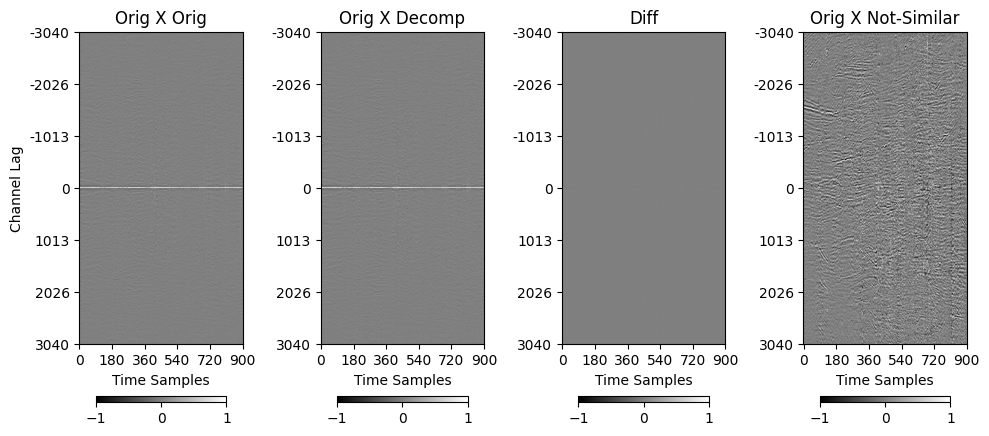

In [ ]:
import matplotlib.ticker as ticker
ptitles = ['Orig X Orig','Orig X Decomp','Diff','Orig X Not-Similar']

# Set the figure size and font size
fig = plt.figure(figsize=(10, 4.8))
plt.rcParams.update({'font.size': 10})

# Plot the subplots
for i, data in enumerate([auto_xcorr, decomp_xcorr, diff_xcorr, nosim_xcorr]):
    ax = fig.add_subplot(1, 4, i+1)
    im = plt.imshow(data,cmap='gray',aspect='auto',vmin=-1,vmax=1)    
    # labels
    if xcorr_axis == -1:
      plt.xlabel('Time Lag')
    else:
      plt.xlabel('Time Samples')
    if i==0:
      if xcorr_axis == -1:
        plt.ylabel('Channels')
      else:
        plt.ylabel('Channel Lag')
    else:
        ax.set_yticklabels([])

    if xcorr_axis == -1:
      #x ticks
      ax.set_xticks(np.linspace(0, 9, 5) * 100)
      ax.set_xticklabels(np.linspace(0, 9, 5) * 100 - 450)
    else:
      #x ticks
      ax.set_xticks(np.arange(6)*180)
      ax.set_xticklabels(np.arange(6) * 180)

      #y ticks
      ax.set_yticks(np.linspace(0, nc/100, 7) * 100)
      yticks = np.linspace(0, nc/100, 7) * 100 - nc/2
      ax.set_yticklabels(yticks.astype(np.int32))

    plt.title(ptitles[i])
    
    # colorbar
    cbar = fig.colorbar(im, orientation="horizontal", shrink=0.8, pad=0.12)
    
    # Title, if desired
    #plt.title('Reconstructed DAS Data')
    
# Adjust the spacing between subplots
fig.tight_layout()
fname = 'correlation_time.png'
if xcorr_axis != -1:
  fname = 'correlation_channel.png'
plt.savefig(root_fqdn+'results/'+fname, dpi=300)
print(root_fqdn+'results/'+fname)

# Show the plot
plt.show()

## Histograms of the difference and the Structural Similarity Measure between Original and Decompressed Data 

### Compute structural similartiy measure

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Structural similarity index
SSIM = []
for y, y_hat in zip(patches_original, patches_decompre):
    y1 = y.numpy().squeeze()
    y2 = y_hat.numpy().squeeze()
    SSIM.append(ssim(y1,y2, data_range=y1.max() - y1.min()))
SSIM = np.array(SSIM)

### Plot histograms (there are two)

* One for the values of the difference between the original data and the decompressed data
* One for the structural similarity for each patch from the original data compared to the decompressed data

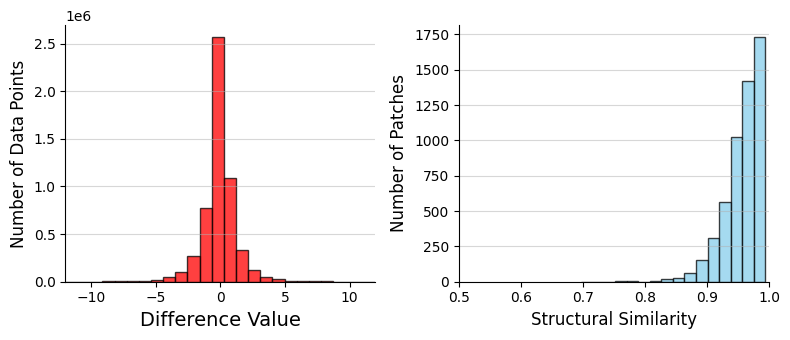

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(1,2,figsize=(8, 3.5))

# Create the histogram
n, bins, patches = ax[0].hist(diff_plt.flatten(), bins=300, edgecolor='black', alpha=0.75, color='#FF0000')

# Customize the appearance
#ax[0].set_xlabel('', fontsize=12)
ax[0].set_ylabel('Number of Data Points', fontsize=12)
ax[0].set_xlabel('Difference Value', fontsize=14)

ax[0].grid(axis='y', alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Customize the tick labels
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].tick_params(axis='both', which='minor', labelsize=8)
ax[0].set_xlim(-12, 12)

# Create the histogram
n, bins, patches = ax[1].hist(SSIM.flatten(), bins=16, edgecolor='black', alpha=0.75, color='#87CEEB')

# Customize the appearance
ax[1].set_xlabel('Structural Similarity', fontsize=12)
ax[1].set_ylabel('Number of Patches', fontsize=12)
# ax[1].set_title('Structural Similarity', fontsize=14)

ax[1].grid(axis='y', alpha=0.5)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Customize the tick labels
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].tick_params(axis='both', which='minor', labelsize=8)
ax[1].set_xlim(0.5, 1)

# Save the figure
plt.tight_layout()
plt.savefig(root_fqdn+'results/histograms.png', dpi=300)

# Show the plot
plt.show()

## Compare frequency spectrums in f-k domain (frequency-wavenumber)

In [ ]:
# Define function for computing specturm and plotting
#def fk_spectrum(signal, time_axis, x_axis, vclip = 0.7, f_lim = None, kx_lim = None, ptitle=''):
def fk_spectrum(signal, time_axis, x_axis, vclip = 0.7, f_lim = None, kx_lim = None, ptitle='',clip=-1,c_spec=None):
       
    # [time axis, spatial axis]
    signal = signal.T
    Nt, Nx = signal.shape
    
    if Nt != time_axis.shape[0] or Nx != x_axis.shape[0]:
        raise ValueError("Wrong size")

    # Perform 2D Fourier Transform
    spectrum = np.fft.fftshift(np.fft.fft2(signal))

    #plot the difference between compute specturm another spectrum
    if c_spec is not None:
      spectrum -= c_spec

    # Generate frequency and wavenumber axes
    dt = time_axis[1] - time_axis[0]
    dx = x_axis[1] - x_axis[0]
    freq_axis = np.fft.fftshift(np.fft.fftfreq(Nt, dt))
    wavenum_axis = np.fft.fftshift(np.fft.fftfreq(Nx, dx))
    
    # Plot F-K spectrum
    plt.figure(figsize=(8, 4))
    pclip = (1.-vclip)*np.abs(spectrum).max()
    if clip != -1:
      pclip = clip
    plt.imshow(np.abs(spectrum), vmin=0, vmax=pclip, aspect='auto', 
               extent=[wavenum_axis.min(), wavenum_axis.max(),freq_axis.min(), freq_axis.max()])

    plt.xlabel('Wavenumber')
    plt.ylabel('Frequency')
    plt.colorbar(label='Amplitude')
    plt.title('F-K Spectrum: '+ptitle)
#     if kx_lim is not None:
#         plt.xlim(kx_lim)
#     if f_lim is not None:
#         plt.ylim(f_lim)
    
    plt.show()
    
    return spectrum, freq_axis, wavenum_axis, pclip


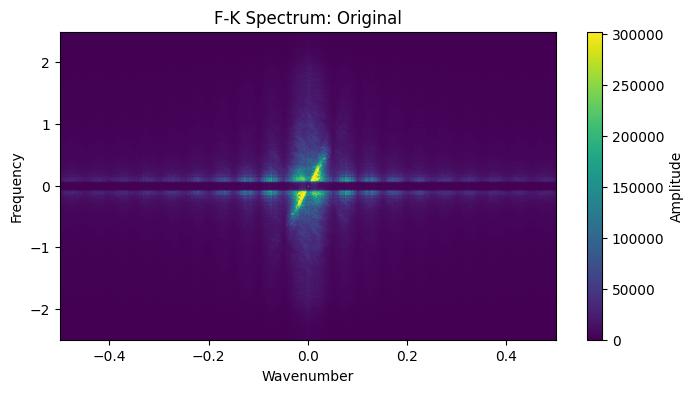

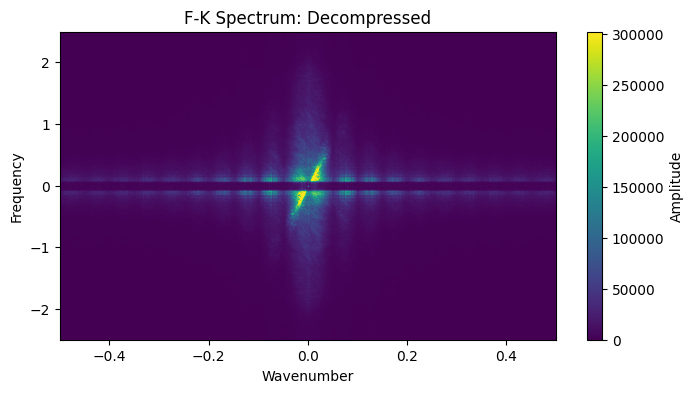

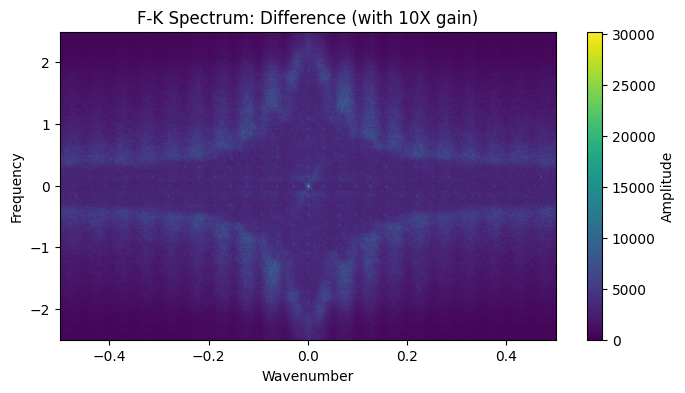

In [ ]:
Nx, Nt = original_das.shape
dt = 1/5    # in seconds
dx = 1     # in meter (Not sure!!!!!)

# Generate synthetic signal
time_axis = np.linspace(0, (nt-1) * dt, nt)
x_axis    = np.linspace(0, (nc-1) * dx, nc)

diff_gain = 0.1

# Perform F-K spectrum analysis
orig_spec, freq_axis, wavenum_axis, pclip = fk_spectrum(orig_plt, time_axis, x_axis, vclip = 0.7, f_lim=[-1, 1], kx_lim=[-0.02, 0.02],ptitle='Original')

decomp_spec, freq_axis, wavenum_axis, junk = fk_spectrum(decom_plt, time_axis, x_axis, vclip = 0.7, f_lim=[-1, 1], kx_lim=[-0.02, 0.02],ptitle='Decompressed',clip=pclip)

diff_spec, freq_axis, wavenum_axis, junk = fk_spectrum(diff_plt, time_axis, x_axis, vclip = 0.7, f_lim=[-1, 1], kx_lim=[-0.02, 0.02],ptitle='Difference (with 10X gain)',clip=diff_gain*pclip)

# Show Model Information


In [ ]:
# show the encoder model
trainer.analysis_transform.summary()


Model: "analysis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 16, 16, 20)        520       
                                                                 
 conv_2 (Conv2D)             (None, 8, 8, 50)          25050     
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 fc_1 (Dense)                (None, 500)               1600500   
                                                                 
 fc_2 (Dense)                (None, 100)               50100     
                                                                 
Total params: 1,676,170
Trainable params: 1,676,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# show the decoder model
trainer.synthesis_transform.summary()


Model: "synthesis_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 500)               50500     
                                                                 
 fc_2 (Dense)                (None, 3200)              1603200   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 50)          0         
                                                                 
 tconv_1 (Conv2DTranspose)   (None, 16, 16, 20)        25020     
                                                                 
 tconv_2 (Conv2DTranspose)   (None, 32, 32, 1)         501       
                                                                 
Total params: 1,679,221
Trainable params: 1,679,221
Non-trainable params: 0
_________________________________________________________________


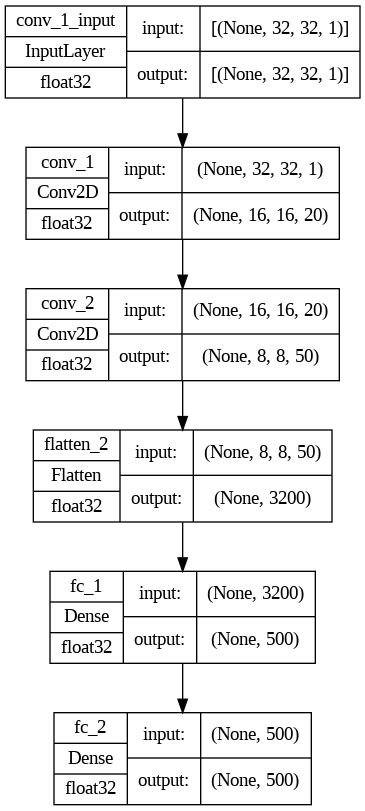

In [ ]:
# plot the encoder model
tf.keras.utils.plot_model(trainer.analysis_transform, to_file='model_analysis_transform.png', show_shapes=True, show_dtype=True)

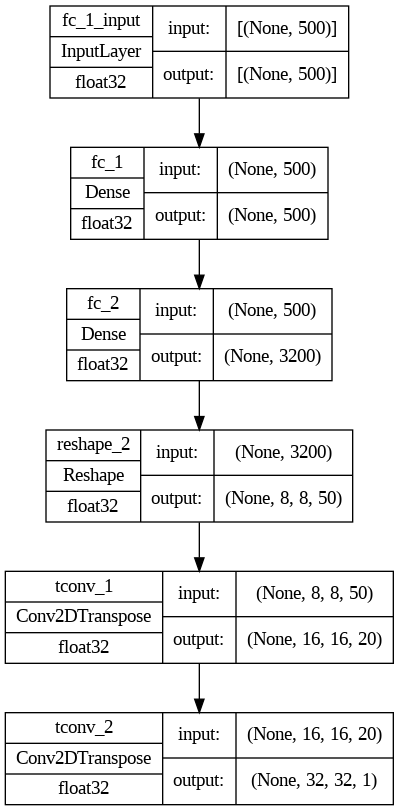

In [ ]:
# plot the decoder model
tf.keras.utils.plot_model(trainer.synthesis_transform, to_file='model_synthesis_transform.png', show_shapes=True, show_dtype=True)